# NMF with SGD implementation and test on Topic modeling

A great way to test the NMF implementation is to test it for the purpose of topic modeling. Here I just use a simple bag of words approach to make things much simpler.

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [6]:
num_topics, num_top_words = 6, 8

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [9]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [10]:
vocab = np.array(vectorizer.get_feature_names())

In [11]:
vocab.shape

(26576,)

In [12]:
vocab[7000:7020]


array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel', 'counselees',
       'counselor', 'count'], 
      dtype='<U80')

In [13]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

# NMF using sklearn first:

In [14]:
m,n=vectors.shape
d=5  # num topics

In [15]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [16]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

# TF-IDF

In [17]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [18]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [19]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

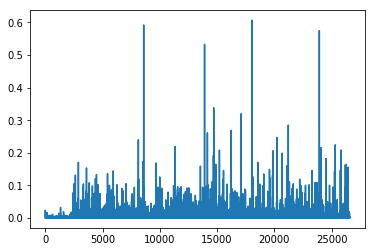

In [20]:
plt.plot(clf.components_[0])

In [21]:
clf.reconstruction_err_

43.712926057952771

In [22]:
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

In [23]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [24]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

# Implement NMF using SGD:

In [25]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [26]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

In [27]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [28]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [29]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [30]:
report(vectors_tfidf, W, H)


44.4262512461 5.36729328234e-07 6.3058150676e-08 0 0


In [31]:
upd(vectors_tfidf,W,H,lr)

In [32]:
report(vectors_tfidf, W, H)

44.4185077999 -0.00105088868452 -7.82307074273e-05 149 265


In [36]:
for i in range(100): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.094207665 -0.000884076287693 -0.000205332286956 147 8196
44.0786469758 -0.000829612215194 -0.000229645666092 162 8545
44.0599452503 -0.000793529134856 -0.0019624305916 175 8635
44.0394627631 -0.00146336770738 -0.000600888761353 185 8817
44.021933757 -0.000972864513717 -0.000651265275742 190 9219
43.99777542 -0.0012757865755 -0.000426954247369 194 8647
43.9795353355 -0.00158218399627 -0.000850344232505 190 9069
43.9590079635 -0.00191313463272 -0.000504701153006 175 8950
43.9420154848 -0.00172113395522 -0.00169175268633 194 9086
43.9243183276 -0.00182100043363 -0.00081891311572 179 9141


In [37]:
show_topics(H)

['god people jesus don just bible christian believe',
 'space nasa don people think question shuttle post',
 'god objective think morality just say believe does',
 'space graphics like know comp nasa lot just',
 'files image file thanks graphics format program windows']

# **This is very slow!**